# Investigation of the Kipf and Welling Propagation Rule
Read below sources for context.
 - Blog post by Kipf: https://tkipf.github.io/graph-convolutional-networks/
 - Paper on arXiv: https://arxiv.org/pdf/1609.02907.pdf

In [1]:
from pprint import pprint
import numpy as np
from scipy.linalg import fractional_matrix_power

def power(matrix, fraction):
    return np.matrix(fractional_matrix_power(matrix, fraction))

In [2]:
A = np.matrix([
    [0, 1, 0, 0],
    [0, 0, 1, 1], 
    [0, 1, 0, 0],
    [1, 0, 1, 0]],
    dtype=float
)
A

matrix([[0., 1., 0., 0.],
        [0., 0., 1., 1.],
        [0., 1., 0., 0.],
        [1., 0., 1., 0.]])

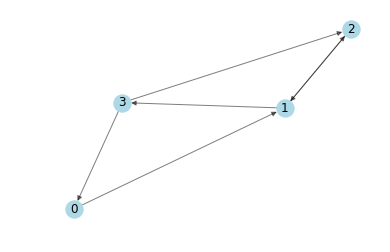

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from networkx import (
    from_numpy_matrix, DiGraph,
    draw_networkx_nodes, draw_networkx_labels, 
    draw_networkx_edges,
    spring_layout)

G = from_numpy_matrix(A, create_using=DiGraph())
pos = spring_layout(G)

draw_networkx_nodes(G, pos, node_color='lightblue')
draw_networkx_edges(G,pos,width=1.0,alpha=0.5)

labels = dict(zip(G.nodes(), G.nodes()))
draw_networkx_labels(G, pos, labels, font_size=12)
plt.axis('off')
plt.savefig('../reports/figures/simple_graph.png')

In [4]:
X = np.matrix([
    [i, -i]
    for i in range(A.shape[0])
], dtype=float)
X

matrix([[ 0.,  0.],
        [ 1., -1.],
        [ 2., -2.],
        [ 3., -3.]])

In [5]:
I = np.matrix(np.eye(A.shape[0]))
I

matrix([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])

# Naive Propagation Rule
Represents a node as the **sum** of neighboring (connected by an in edge) nodes' features.

In [6]:
A

matrix([[0., 1., 0., 0.],
        [0., 0., 1., 1.],
        [0., 1., 0., 0.],
        [1., 0., 1., 0.]])

In [7]:
pprint(X)
A * X

matrix([[ 0.,  0.],
        [ 1., -1.],
        [ 2., -2.],
        [ 3., -3.]])


matrix([[ 1., -1.],
        [ 5., -5.],
        [ 1., -1.],
        [ 2., -2.]])

## Add Self Loop
Equivalent to the above, but the node's own features is always included in the sum.

In [8]:
pprint(X)
A_hat = A + I
A_hat * X

matrix([[ 0.,  0.],
        [ 1., -1.],
        [ 2., -2.],
        [ 3., -3.]])


matrix([[ 1., -1.],
        [ 6., -6.],
        [ 3., -3.],
        [ 5., -5.]])

# Normalized Propagation
Normalizes the features by node degree. Represents a node as the **mean** of neighboring (connected by an in edge) nodes' features. 

In [9]:
# Compute Degree Matrix
D = np.array(np.sum(A, axis=0))[0]
D = np.matrix(np.diag(D))
D

matrix([[1., 0., 0., 0.],
        [0., 2., 0., 0.],
        [0., 0., 2., 0.],
        [0., 0., 0., 1.]])

In [10]:
D**-1 * A

matrix([[0. , 1. , 0. , 0. ],
        [0. , 0. , 0.5, 0.5],
        [0. , 0.5, 0. , 0. ],
        [1. , 0. , 1. , 0. ]])

In [11]:
pprint(X)
D**-1 * A * X

matrix([[ 0.,  0.],
        [ 1., -1.],
        [ 2., -2.],
        [ 3., -3.]])


matrix([[ 1. , -1. ],
        [ 2.5, -2.5],
        [ 0.5, -0.5],
        [ 2. , -2. ]])

## Add Self Loop
Equivalent to the above, but the node's own features is always included in the mean.

In [12]:
D_hat = np.array(np.sum(A_hat, axis=0))[0]
D_hat = np.matrix(np.diag(D_hat))
D_hat

matrix([[2., 0., 0., 0.],
        [0., 3., 0., 0.],
        [0., 0., 3., 0.],
        [0., 0., 0., 2.]])

In [13]:
D_hat**-1 * A_hat

matrix([[0.5       , 0.5       , 0.        , 0.        ],
        [0.        , 0.33333333, 0.33333333, 0.33333333],
        [0.        , 0.33333333, 0.33333333, 0.        ],
        [0.5       , 0.        , 0.5       , 0.5       ]])

In [14]:
pprint(X)
D_hat**-1 * A_hat * X

matrix([[ 0.,  0.],
        [ 1., -1.],
        [ 2., -2.],
        [ 3., -3.]])


matrix([[ 0.5, -0.5],
        [ 2. , -2. ],
        [ 1. , -1. ],
        [ 2.5, -2.5]])

# Symmetric Normalization
Represents a node as a **weighted sum** of neighboring (connected by an in edge) nodes' features. The weight of a neighbor $n$ of $v$ is $\deg(v)^{0.5} \cdot \deg(n)^{0.5}$.

In [15]:
pprint(A)
pprint(D)
power(D, -0.5)

matrix([[0., 1., 0., 0.],
        [0., 0., 1., 1.],
        [0., 1., 0., 0.],
        [1., 0., 1., 0.]])
matrix([[1., 0., 0., 0.],
        [0., 2., 0., 0.],
        [0., 0., 2., 0.],
        [0., 0., 0., 1.]])


matrix([[1.        , 0.        , 0.        , 0.        ],
        [0.        , 0.70710678, 0.        , 0.        ],
        [0.        , 0.        , 0.70710678, 0.        ],
        [0.        , 0.        , 0.        , 1.        ]])

In [16]:
power(D, -0.5) * A # Apply weight for own degree

matrix([[0.        , 1.        , 0.        , 0.        ],
        [0.        , 0.        , 0.70710678, 0.70710678],
        [0.        , 0.70710678, 0.        , 0.        ],
        [1.        , 0.        , 1.        , 0.        ]])

In [17]:
power(D, -0.5) * A * power(D, -0.5) # Apply weight for neighbor degree

matrix([[0.        , 0.70710678, 0.        , 0.        ],
        [0.        , 0.        , 0.5       , 0.70710678],
        [0.        , 0.5       , 0.        , 0.        ],
        [1.        , 0.        , 0.70710678, 0.        ]])

In [18]:
pprint(power(D, -0.5) * A) # Apply weight for own degree
pprint(power(D, -0.5) * A * power(D, -0.5)) # Apply weight for neighbor degree

matrix([[0.        , 1.        , 0.        , 0.        ],
        [0.        , 0.        , 0.70710678, 0.70710678],
        [0.        , 0.70710678, 0.        , 0.        ],
        [1.        , 0.        , 1.        , 0.        ]])
matrix([[0.        , 0.70710678, 0.        , 0.        ],
        [0.        , 0.        , 0.5       , 0.70710678],
        [0.        , 0.5       , 0.        , 0.        ],
        [1.        , 0.        , 0.70710678, 0.        ]])


In [19]:
pprint(D**-1 * A)
pprint(power(D, -0.75) * A * power(D, -0.25)) # Importance of neighbor degree decreases
pprint(power(D, -0.25) * A * power(D, -0.75)) # Importance of neighbor degree increases
pprint(power(D, -1.0) * A * power(D, -0.0)) # Is a generalization of asymmetric normalization

matrix([[0. , 1. , 0. , 0. ],
        [0. , 0. , 0.5, 0.5],
        [0. , 0.5, 0. , 0. ],
        [1. , 0. , 1. , 0. ]])
matrix([[0.        , 0.84089642, 0.        , 0.        ],
        [0.        , 0.        , 0.5       , 0.59460356],
        [0.        , 0.5       , 0.        , 0.        ],
        [1.        , 0.        , 0.84089642, 0.        ]])
matrix([[0.        , 0.59460356, 0.        , 0.        ],
        [0.        , 0.        , 0.5       , 0.84089642],
        [0.        , 0.5       , 0.        , 0.        ],
        [1.        , 0.        , 0.59460356, 0.        ]])
matrix([[0. , 1. , 0. , 0. ],
        [0. , 0. , 0.5, 0.5],
        [0. , 0.5, 0. , 0. ],
        [1. , 0. , 1. , 0. ]])


In [20]:
pprint(X)
power(D, -0.5) * A * power(D, -0.5) * X

matrix([[ 0.,  0.],
        [ 1., -1.],
        [ 2., -2.],
        [ 3., -3.]])


matrix([[ 0.70710678, -0.70710678],
        [ 3.12132034, -3.12132034],
        [ 0.5       , -0.5       ],
        [ 1.41421356, -1.41421356]])

##  Add Self Loops

In [21]:
power(D_hat, -0.5) * A_hat * power(D_hat, -0.5)

matrix([[0.5       , 0.40824829, 0.        , 0.        ],
        [0.        , 0.33333333, 0.33333333, 0.40824829],
        [0.        , 0.33333333, 0.33333333, 0.        ],
        [0.5       , 0.        , 0.40824829, 0.5       ]])

In [22]:
pprint(X)
power(D_hat, -0.5) * A_hat * power(D_hat, -0.5) * X

matrix([[ 0.,  0.],
        [ 1., -1.],
        [ 2., -2.],
        [ 3., -3.]])


matrix([[ 0.40824829, -0.40824829],
        [ 2.22474487, -2.22474487],
        [ 1.        , -1.        ],
        [ 2.31649658, -2.31649658]])

In [23]:
power(D_hat, -0.5) * A_hat * power(D_hat, -0.5) * X * np.matrix([[1, -1], [0, 0]])

matrix([[ 0.40824829, -0.40824829],
        [ 2.22474487, -2.22474487],
        [ 1.        , -1.        ],
        [ 2.31649658, -2.31649658]])

# Desimplification

# Add Weights

In [24]:
D_hat**-1 * A_hat * X

matrix([[ 0.5, -0.5],
        [ 2. , -2. ],
        [ 1. , -1. ],
        [ 2.5, -2.5]])

In [25]:
W = np.matrix([
    [1, -1], [-1, 1]
])
D_hat**-1 * A_hat * X * W

matrix([[ 1., -1.],
        [ 4., -4.],
        [ 2., -2.],
        [ 5., -5.]])

In [26]:
W = np.matrix([
    [1], [-1]
])
D_hat**-1 * A_hat * X * W

matrix([[1.],
        [4.],
        [2.],
        [5.]])

In [27]:
def relu(m):
   return np.maximum(m, 0)

In [28]:
W = np.matrix([
    [1, -1], [-1, 1]
])
relu(D_hat**-1 * A_hat * X * W)

matrix([[1., 0.],
        [4., 0.],
        [2., 0.],
        [5., 0.]])

# Embedding Zachary's Karate Club

Instructor


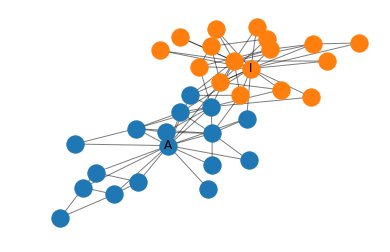

In [8]:
from networkx import (
    karate_club_graph,
    spring_layout, draw_networkx_nodes, draw_networkx_edges, draw_networkx_labels,
    set_node_attributes,
    write_edgelist
)
import matplotlib.pyplot as plt
from csv import DictWriter
zkc = karate_club_graph()

pos = spring_layout(zkc)

administrator = set(
    n -1 for n in (1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 17, 18, 20, 22))
instructor = set(node for node in zkc.nodes() if node not in administrator)

draw_networkx_nodes(zkc, pos, nodelist=[0], node_size=300, node_color='C0')
draw_networkx_nodes(zkc, pos, nodelist=list(administrator - set([0])), node_color='C0')

draw_networkx_nodes(zkc, pos, nodelist=[33], node_size=300, node_color='C1')
draw_networkx_nodes(zkc, pos, nodelist=list(instructor - set([33])), node_color='C1')

#draw_networkx_nodes(zkc, pos, node_color='lightblue')
draw_networkx_edges(zkc, pos,width=1.0,alpha=0.5)

labels = {33: 'I', 0: 'A'}
draw_networkx_labels(zkc, pos, labels, font_size=12)
plt.axis('off')
plt.savefig('../reports/figures/karateclub_visualised.pdf')

In [8]:
def gcn_layer(A_hat, D_hat, X, W):
    return relu(D_hat**-1 * A_hat * X * W)

In [9]:
from networkx import to_numpy_matrix
def gcn_layer(A_hat, D_hat, X, W):
    return relu(D_hat**-1 * A_hat * X * W)

zkc = karate_club_graph()
order = sorted(list(zkc.nodes()))

A = to_numpy_matrix(zkc, nodelist=order)
I = np.eye(zkc.number_of_nodes())

A_hat = A + I
D_hat = np.array(np.sum(A_hat, axis=0))[0]
D_hat = np.matrix(np.diag(D_hat))

NameError: name 'np' is not defined

In [10]:
W_1 = np.random.normal(loc=0, size=(zkc.number_of_nodes(), 4)) * np.sqrt(zkc.number_of_nodes())
W_2 = np.random.normal(loc=0, size=(W_1.shape[1], 2)) * np.sqrt(W_1.shape[1])

NameError: name 'np' is not defined

In [400]:
W_1_ = (W_1 / np.sqrt(zkc.number_of_nodes())) * np.sqrt(2/zkc.number_of_nodes())
W_2_ = (W_2 / np.sqrt(W_1.shape[1])) *  np.sqrt(2/W_1.shape[1])
H_1 = gcn_layer(A_hat, D_hat, I, W_1)
H_2 = gcn_layer(A_hat, D_hat, H_1, W_2)

output = H_2
output

matrix([[ 2.63293008,  7.43778465],
        [ 2.24505092,  2.91362338],
        [ 2.83026642,  0.5634119 ],
        [ 1.08966081,  0.32438816],
        [ 1.79323777, 13.79109651],
        [ 3.06628699, 18.25658238],
        [ 3.21941518, 17.28625863],
        [ 0.70127455,  0.50411151],
        [ 1.5775419 ,  1.19264042],
        [ 2.41248938,  0.        ],
        [ 0.42243448, 17.10532581],
        [ 0.86754691,  3.90286076],
        [ 0.6058438 ,  0.96613536],
        [ 1.33205488,  0.47538461],
        [ 8.36241182,  4.64927433],
        [ 4.62180863,  7.0732635 ],
        [ 5.1135601 , 22.35850875],
        [ 1.70646141,  1.69760565],
        [ 5.86441444,  9.13353296],
        [ 4.25920495,  3.22131688],
        [ 5.26073025,  6.0839208 ],
        [ 0.82100255,  5.53144834],
        [ 6.53179582,  2.39148119],
        [ 2.73306619,  5.16939565],
        [ 3.70424684,  6.16738001],
        [ 3.51263702,  6.9258294 ],
        [ 5.18609157,  3.74912318],
        [ 1.83819583,  2.392

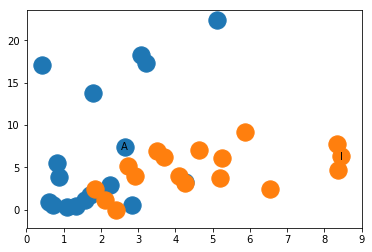

In [401]:
%matplotlib inline
import matplotlib.pyplot as plt
embedding = {node: np.array(output)[node] for node in zkc.nodes()}

s=300
plt.scatter(*embedding[0], c='C0', s=s)
plt.annotate('A', xy=embedding[0], ha='center', va='center')
x, y = zip(*[embedding[node] for node in administrator - set([0])])
plt.scatter(x, y, c='C0', s=s)

plt.scatter(*embedding[33], c='C1', s=s)
plt.annotate('I', xy=embedding[33], ha='center', va='center')
x, y = zip(*[embedding[node] for node in instructor- set([33])])
plt.scatter(x, y, c='C1', s=s)
plt.savefig('../reports/figures/randomly_initialized_2layer_GCN_on_karate_club.pdf')